In [179]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder, Imputer
import math

In [304]:
X_load = pd.read_csv("Data/train.csv")
X_load.head()
test = pd.read_csv("Data/test.csv")

Text(0.5,1,'Fare paid (sorted values)')

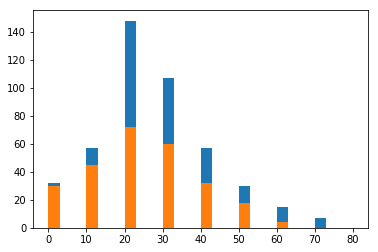

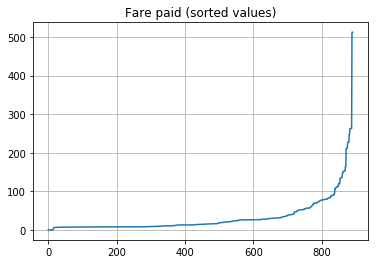

In [38]:
"""Playing with data"""
aM = X_load[X_load["Sex"]=="male"]
aM = aM["Age"].dropna()
aF = X_load[X_load["Sex"]=="female"]
aF = aF["Age"].dropna()
plt.hist(aM, bins=8, width=3, range=[0, 80])
plt.hist(aF, bins=8, width=3, range=[0, 80], align="mid")
#print(min(ageDist), max(ageDist))

plt.figure()
plt.plot(X_load["Fare"].sort_values().values)
plt.grid()
plt.title("Fare paid (sorted values)")

In [306]:
"""Data Clean up"""
""" Assumptions:
- Name is irrelevant to survival
- Ticket ID is irrelevant too
- Cabin number could be relevant if mapped to distance to boats/exits but info not provided so irrelvant
- Port in which they embarked is likely to be irrelevant. Could be useful if nationality was at play but in the disaster likely not to be

Data engineering:
"""
Y_train = X_load["Survived"]

X_train = X_load[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]
X_test = test[["Pclass", "Sex", "Age", "SibSp", "Parch", "Fare"]]
# Encode Sex into 0 or 1
encoder = LabelEncoder()
X_train["Sex"]=encoder.fit_transform(X_train["Sex"])
X_test["Sex"]=encoder.fit_transform(X_test["Sex"])

#print(X_train["Sex"].value_counts()) # indicate which is male, which is female

C:\Users\Alexandre_Bondoux\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
C:\Users\Alexandre_Bondoux\Anaconda3\lib\site-packages\ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


C:\Users\Alexandre_Bondoux\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:52: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead
  return getattr(obj, method)(*args, **kwds)


Text(0.5,1,'Repartition per traveler class')

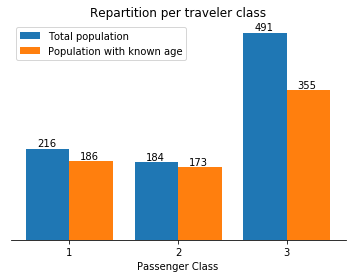

In [195]:
# Problem: we have some unknown age values
# To be relevant, we need to populate them or remove them.
plt.figure()
df = X_train.dropna()
n, bins, _ = plt.hist([X_train["Pclass"], df["Pclass"]], bins=3, align = "left", width=0.4, range=(1, 4), label=["Total population", "Population with known age"])
plt.xticks(np.arange(1, 4))
plt.legend()
# Add values on top of hist
for i, v in enumerate(X_train["Pclass"].value_counts().sort_index()):
    plt.text(i+1-0.3, v+5, v)
for i, v in enumerate(df["Pclass"].value_counts().sort_index()):
    plt.text(i+1+0.1, v+5, v)
plt.tick_params(axis="y", left="off", right="off", labelleft="off", labelcolor="red", labelrotation=45, gridOn=False)
plt.gca().spines["left"].set_visible(False)
plt.gca().spines["top"].set_visible(False)
plt.gca().spines["right"].set_visible(False)
plt.xlabel("Passenger Class")
plt.title("Repartition per traveler class")

In [313]:
# Conclusion: we can fill in the blanks for class 1 and 2 but for 3 it will start to be a bit random.
#imputer = Imputer(strategy="most_frequent")
X_train.loc[pd.isnull(X_train["Age"]), "Age"]=X_train["Age"].median()
X_test.loc[pd.isnull(X_test["Age"]), "Age"]=X_test["Age"].median()
X_test.loc[pd.isnull(X_test["Fare"]), "Fare"]=X_test["Fare"].median()


C:\Users\Alexandre_Bondoux\Anaconda3\lib\site-packages\pandas\core\indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [219]:
sgd = SGDClassifier()
sgd_scores = cross_val_score(sgd, X_train, Y_train, cv=100, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.0s finished


0.6368611111111111

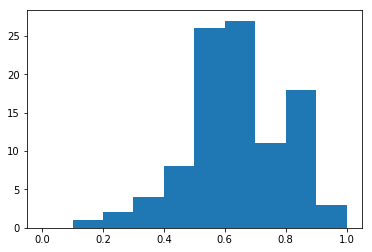

In [220]:
plt.figure()
plt.hist(sgd_scores, bins=10, range=(0, 1))
sgd_scores.mean()

In [244]:
# Conclusion of this round: not great
# Let's try the other models (KNN, Random Forest)
# Then we will do a grid search

from sklearn.neighbors import KNeighborsClassifier

knn=KNeighborsClassifier()
knn_scores = cross_val_score(knn, X_train, Y_train, cv=100, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.1s finished


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

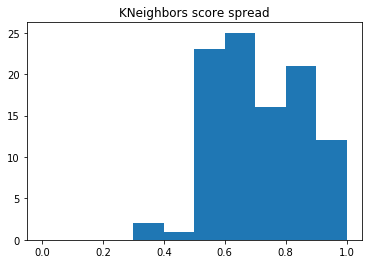

In [246]:
plt.figure()
plt.hist(knn_scores, bins=10, range=(0, 1))
plt.title("KNeighbors score spread")
knn_scores.mean()
knn

In [229]:
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor()
rfr_scores = cross_val_score(rfr, X_train, Y_train, cv=100, n_jobs=-1, verbose=2)

[Parallel(n_jobs=-1)]: Done  36 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    3.7s finished


0.28165340136104833

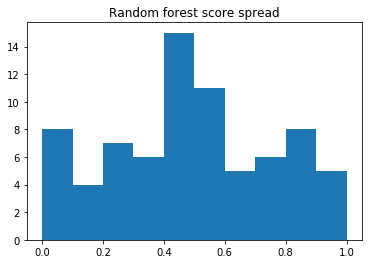

In [230]:
plt.figure()
plt.hist(rfr_scores, bins=10, range=(0, 1))
plt.title("Random forest score spread")
rfr_scores.mean()

In [301]:
from sklearn.model_selection import GridSearchCV

param_grid = {"leaf_size": [30], \
              "n_neighbors":np.arange(10, 40, 2), \
              "algorithm":["auto"], \
              "metric": ["minkowski"], \
              "p": [2], \
              "weights": ["distance"]}
gridSearch = GridSearchCV(knn, param_grid=param_grid, verbose=2, pre_dispatch=2, cv=100)

In [302]:
gridSearch.fit(X_train, Y_train)

Fitting 100 folds for each of 15 candidates, totalling 1500 fits
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=mink

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV] 

[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=10, p=2, weights=distance, total=   0.0s
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=12, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=14, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=16, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=18, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=20, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=22, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=24, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=26, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=28, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=30, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV] 

[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=32, p=2, weights=distance, total=   0.0s
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=34, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=36, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV] 

[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV]  algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance, total=   0.0s
[CV] algorithm=auto, leaf_size=30, metric=minkowski, n_neighbors=38, p=2, weights=distance 
[CV] 

[Parallel(n_jobs=1)]: Done 1500 out of 1500 | elapsed:   15.3s finished


GridSearchCV(cv=100, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'leaf_size': [30], 'n_neighbors': array([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38]), 'algorithm': ['auto'], 'metric': ['minkowski'], 'p': [2], 'weights': ['distance']},
       pre_dispatch=2, refit=True, return_train_score='warn', scoring=None,
       verbose=2)

In [303]:
cvrs=gridSearch.cv_results_
print(cvrs["mean_test_score"].max(), 
     cvrs["mean_test_score"].mean())
print(cvrs["params"][cvrs["mean_test_score"].argmax()])

0.7418630751964085 0.7382716049382714
{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'n_neighbors': 22, 'p': 2, 'weights': 'distance'}


In [315]:
X_test.describe()

,Pclass,Sex,Age,SibSp,Parch,Fare
count,418.000000,418.000000,418.000000,418.000000,418.000000,418.000000
mean,2.265550,0.636364,29.599282,0.447368,0.392344,35.576535
std,0.841838,0.481622,12.703770,0.896760,0.981429,55.850103
min,1.000000,0.000000,0.170000,0.000000,0.000000,0.000000
25%,1.000000,0.000000,23.000000,0.000000,0.000000,7.895800
50%,3.000000,1.000000,27.000000,0.000000,0.000000,14.454200
75%,3.000000,1.000000,35.750000,1.000000,0.000000,31.471875
max,3.000000,1.000000,76.000000,8.000000,9.000000,512.329200


In [318]:
final_model = gridSearch.best_estimator_

In [320]:
result = final_model.predict(X_test)

In [322]:
# Create the final DataFrame to export
df = pd.DataFrame()
df["PassengerId"] = np.arange(892, 1310, 1)
df["Survived"] = result

In [326]:
# You need to delete the index column afterward
df.to_csv("Data/submission.csv")